In [1]:
print("=== STEP 1: Installing & importing ===")
!pip install -q transformers timm kaggle pillow opencv-python scikit-learn matplotlib seaborn torchvision onnxruntime

import os, random, shutil, re, sys
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from transformers import ViTModel, ViTConfig
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

print("✓ Libraries ready")

=== STEP 1: Installing & importing ===
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.6 MB/s eta 0:00:00
✓ Libraries ready


In [2]:
print("\n=== STEP 2: GPU & random seed ===")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)
if torch.cuda.is_available():
    try:
        print("GPU:", torch.cuda.get_device_name(0))
    except: pass

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

set_seed(42)
print("✓ Seed set")


=== STEP 2: GPU & random seed ===
Device: cuda
GPU: Tesla T4
✓ Seed set


In [3]:
os.makedirs('/root/.kaggle', exist_ok=True)

In [4]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
for fn in uploaded.keys():
    shutil.move(fn, '/root/.kaggle/kaggle.json')

In [6]:
os.chmod('/root/.kaggle/kaggle.json', 0o600)

In [7]:
!kaggle datasets download -d shreyanshmanavshukla/celebsv2-faces-224 -p /content/celeb_df_data --unzip

Dataset URL: https://www.kaggle.com/datasets/shreyanshmanavshukla/celebsv2-faces-224
License(s): apache-2.0
  0% 0.00/105M [00:00<?, ?B/s]
100% 105M/105M [00:00<00:00, 1.71GB/s]


In [8]:
print("\n=== STEP 3: Locate dataset under /content and set DATA_DIR ===")
# If you know exact path, set it here; otherwise leave None to auto-detect.
DATA_DIR = None

SEARCH_ROOT = Path('/content')
def find_image_dirs(root=SEARCH_ROOT, exts=('.jpg','.jpeg','.png')):
    c = Counter()
    for f in root.rglob('*'):
        if f.is_file() and f.suffix.lower() in exts:
            c[f.parent] += 1
    return c.most_common()

candidates = find_image_dirs()
if DATA_DIR is None:
    if len(candidates) == 0:
        raise RuntimeError("No images found under /content. Upload/unzip dataset into /content or mount Drive.")
    best_dir, best_count = candidates[0]
    DATA_DIR = str(best_dir)
    print(f"[AUTO] Selected DATA_DIR = {DATA_DIR}  (images found: {best_count})")
else:
    print(f"[USER] Using explicit DATA_DIR = {DATA_DIR}")

p = Path(DATA_DIR)
if not p.exists():
    raise FileNotFoundError(f"DATA_DIR not found: {DATA_DIR}")
print("Sample files (first 30):")
cnt = 0
for f in sorted(p.iterdir()):
    print(" ", f.name)
    cnt += 1
    if cnt >= 30: break
total_images = sum(1 for _ in p.rglob('*.jpg')) + sum(1 for _ in p.rglob('*.png'))
print("Total images found under DATA_DIR:", total_images)
if total_images == 0:
    raise RuntimeError("No images under chosen DATA_DIR. Check unzip location or nested zip.")

if '{' in DATA_DIR or 'DATA_DIR' in Path(DATA_DIR).parts[-1]:
    suggested = str(p).replace('{','').replace('}','').replace('DATA_DIR','celeb_images')
    print(f"[INFO] Suggested rename to clean path: {suggested}")
    try:
        Path(suggested).parent.mkdir(parents=True, exist_ok=True)
        p.rename(suggested)
        DATA_DIR = suggested
        p = Path(DATA_DIR)
        print("[INFO] Renamed. New DATA_DIR:", DATA_DIR)
    except Exception as e:
        print("[WARN] Rename failed:", e)



=== STEP 3: Locate dataset under /content and set DATA_DIR ===
[AUTO] Selected DATA_DIR = /content/celeb_df_data/CelebsV2_Faces_224/CelebsV2_Faces_224  (images found: 6529)
Sample files (first 30):
  00000.jpg
  00001.jpg
  00002.jpg
  00003.jpg
  00004.jpg
  00005.jpg
  00006.jpg
  00007.jpg
  00008.jpg
  00009.jpg
  00010.jpg
  00011.jpg
  00012.jpg
  00013.jpg
  00014.jpg
  00015.jpg
  00016.jpg
  00017.jpg
  00018.jpg
  00019.jpg
  00020.jpg
  00021.jpg
  00022.jpg
  00023.jpg
  00024.jpg
  00025.jpg
  00026.jpg
  00027.jpg
  00028.jpg
  00029.jpg
Total images found under DATA_DIR: 6529


In [9]:
print("\n=== STEP 4: Build labels using filename heuristic (and save CSV) ===")
single_id_assumed_label = 0  # 0 for REAL, 1 for FAKE (change if needed)

files = sorted([f for f in p.iterdir() if f.is_file() and f.suffix.lower() in ('.jpg','.jpeg','.png')])
rows = []
rx_two_ids = re.compile(r'(id\d+).*?(id\d+)', re.IGNORECASE)
rx_numeric = re.compile(r'^\d+\.(jpg|jpeg|png)$', re.IGNORECASE)
for fpath in files:
    name = fpath.name
    if rx_two_ids.search(name):
        label = 1
    elif rx_numeric.match(name):
        label = 0
    elif re.search(r'id\d+', name, re.IGNORECASE):
        label = single_id_assumed_label
    else:
        label = None
    if label is not None:
        rows.append({'image_path': name, 'label': label})

df_labels = pd.DataFrame(rows)
print("Labeled images:", len(df_labels), " / ", len(files))
print("Label distribution:\n", df_labels['label'].value_counts())

if len(df_labels) == 0:
    raise RuntimeError("Labeling heuristic produced 0 labeled images. Provide CSV or change heuristic.")

labels_csv_path = p / 'labels_by_heuristic.csv'
df_labels.to_csv(labels_csv_path, index=False)
print("Saved heuristic labels CSV:", labels_csv_path)

print("\nSample REAL (label=0):")
display(df_labels[df_labels['label']==0].sample(min(8, len(df_labels[df_labels['label']==0]))) )
print("\nSample FAKE (label=1):")
display(df_labels[df_labels['label']==1].sample(min(8, len(df_labels[df_labels['label']==1]))))



=== STEP 4: Build labels using filename heuristic (and save CSV) ===
Labeled images: 6529  /  6529
Label distribution:
 label
1    5639
0     890
Name: count, dtype: int64
Saved heuristic labels CSV: /content/celeb_df_data/CelebsV2_Faces_224/CelebsV2_Faces_224/labels_by_heuristic.csv

Sample REAL (label=0):


,image_path,label
280,00280.jpg,0
1666,id23_0006.jpg,0
39,00039.jpg,0
1392,id21_0009.jpg,0
3794,id37_0006.jpg,0
5982,id58_0004.jpg,0
511,id13_0004.jpg,0
4698,id45_0009.jpg,0



Sample FAKE (label=1):


,image_path,label
5877,id56_id54_0008.jpg,1
2808,id2_id37_0000.jpg,1
5572,id53_id49_0006.jpg,1
6333,id7_id11_0004.jpg,1
6512,id9_id3_0007.jpg,1
1831,id23_id35_0007.jpg,1
1902,id24_id19_0005.jpg,1
3699,id35_id32_0002.jpg,1


In [10]:
print("\n=== STEP 5: Stratified train/test split ===")
train_df, test_df = train_test_split(df_labels, test_size=0.20, stratify=df_labels['label'], random_state=42)
print("Train:", len(train_df), " Test:", len(test_df))



=== STEP 5: Stratified train/test split ===
Train: 5223  Test: 1306


In [11]:
print("\n=== STEP 6: Dataset classes & transforms ===")
class DeepfakeCsvDataset(Dataset):
    def __init__(self, df, root_dir, transform=None, img_col='image_path', label_col='label'):
        self.df = df.reset_index(drop=True)
        self.root = Path(root_dir)
        self.transform = transform
        self.img_col = img_col
        self.label_col = label_col
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_rel = row[self.img_col]
        img_path = self.root / img_rel
        image = Image.open(img_path).convert('RGB')
        label = int(row[self.label_col])
        if self.transform: image = self.transform(image)
        return {'pixel_values': image, 'labels': torch.tensor(label, dtype=torch.long)}

IMG_SIZE = 224
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
print("✓ Transforms defined")



=== STEP 6: Dataset classes & transforms ===
✓ Transforms defined


In [12]:
print("\n=== STEP 7: Create datasets & dataloaders ===")
BATCH_SIZE = 32
NUM_WORKERS = 2

train_dataset = DeepfakeCsvDataset(train_df, DATA_DIR, transform=train_transforms)
test_dataset  = DeepfakeCsvDataset(test_df,  DATA_DIR, transform=val_transforms)

if len(train_dataset) == 0: raise RuntimeError("Train dataset empty — adjust labeling heuristic or supply CSV.")
print("Train samples:", len(train_dataset), "Test samples:", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# Quick batch check
sample_batch = next(iter(train_loader))
print("Sample batch shapes:", sample_batch['pixel_values'].shape, sample_batch['labels'].shape)



=== STEP 7: Create datasets & dataloaders ===
Train samples: 5223 Test samples: 1306
Sample batch shapes: torch.Size([32, 3, 224, 224]) torch.Size([32])


In [13]:
print("\n=== STEP 8: Model (ViT) ===")
class ViTDeepfakeDetector(nn.Module):
    def __init__(self, model_name='google/vit-base-patch16-224', num_classes=2, pretrained=True):
        super().__init__()
        if pretrained:
            self.vit = ViTModel.from_pretrained(model_name)
        else:
            cfg = ViTConfig.from_pretrained(model_name)
            self.vit = ViTModel(cfg)
        self.hidden_size = self.vit.config.hidden_size
        self.classifier = nn.Sequential(
            nn.LayerNorm(self.hidden_size),
            nn.Dropout(0.1),
            nn.Linear(self.hidden_size, 512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )
    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        cls = outputs.last_hidden_state[:,0]
        logits = self.classifier(cls)
        return logits

model = ViTDeepfakeDetector(pretrained=True).to(device)
print("Model parameters:", sum(p.numel() for p in model.parameters()))



=== STEP 8: Model (ViT) ===


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 86785538


In [14]:
print("\n=== STEP 9: Loss & optimizer ===")
criterion = nn.CrossEntropyLoss()
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01
optimizer = torch.optim.AdamW([
    {'params': model.vit.parameters(), 'lr': LEARNING_RATE * 0.1},
    {'params': model.classifier.parameters(), 'lr': LEARNING_RATE}
], weight_decay=WEIGHT_DECAY)
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
print("Optimizer & scheduler ready")



=== STEP 9: Loss & optimizer ===
Optimizer & scheduler ready


In [15]:
print("\n=== STEP 10: Train & Validate functions ===")
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss=0.0; correct=0; total=0
    pbar = tqdm(dataloader, desc='Training')
    for batch in pbar:
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(pixel_values)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()
        _,pred = outputs.max(1)
        total += labels.size(0); correct += pred.eq(labels).sum().item()
        pbar.set_postfix({'loss': f'{running_loss/len(pbar):.4f}', 'acc': f'{100.*correct/total:.2f}%'})
    return running_loss / len(dataloader), 100. * correct / total

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss=0.0; all_preds=[]; all_labels=[]; all_probs=[]
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for batch in pbar:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(pixel_values)
            loss = criterion(outputs, labels)
            probs = F.softmax(outputs, dim=1)
            _,pred = outputs.max(1)
            running_loss += loss.item()
            all_preds.extend(pred.cpu().numpy()); all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:,1].cpu().numpy())
    epoch_loss = running_loss / len(dataloader) if len(dataloader)>0 else 0.0
    accuracy = accuracy_score(all_labels, all_preds) if len(all_labels)>0 else 0.0
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary') if len(all_labels)>0 else (0,0,0,[0])
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except:
        auc = 0.0
    return {'loss': epoch_loss, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': auc, 'predictions': all_preds, 'labels': all_labels, 'probs': all_probs}

print("Train/Validate functions ready")



=== STEP 10: Train & Validate functions ===
Train/Validate functions ready


In [16]:
print("\n=== STEP 11: Training loop ===")
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=10, save_dir='./checkpoints'):
    os.makedirs(save_dir, exist_ok=True)
    history={'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[],'val_f1':[],'val_auc':[]}
    best_f1 = 0.0
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_metrics = validate(model, test_loader, criterion, device)
        scheduler.step()
        history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
        history['val_loss'].append(val_metrics['loss']); history['val_acc'].append(val_metrics['accuracy']*100)
        history['val_f1'].append(val_metrics['f1']); history['val_auc'].append(val_metrics['auc'])
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_metrics['loss']:.4f} | Val Acc: {val_metrics['accuracy']*100:.2f}%")
        print(f"Val F1: {val_metrics['f1']:.4f} | Val AUC: {val_metrics['auc']:.4f}")
        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            ckpt_path = os.path.join(save_dir, 'best_model.pth')
            torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'f1': best_f1, 'metrics': val_metrics}, ckpt_path)
            # ALSO save a clean state_dict to avoid future unpickling issues
            torch.save(model.state_dict(), os.path.join(save_dir, 'best_model_state_dict.pth'))
            print("✓ Best model saved (both full ckpt and clean state_dict)")
        if (epoch+1) % 5 == 0:
            torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}.pth'))
    return history

print("Training loop ready. Example call (commented):")
print("# history = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=20)")



=== STEP 11: Training loop ===
Training loop ready. Example call (commented):
# history = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=20)


In [17]:
print("\n=== STEP 12: Visualization & save helpers ===")
def plot_training_history(history):
    fig, axes = plt.subplots(2,2,figsize=(14,10))
    axes[0,0].plot(history['train_loss']); axes[0,0].plot(history['val_loss']); axes[0,0].set_title('Loss')
    axes[0,1].plot(history['train_acc']); axes[0,1].plot(history['val_acc']); axes[0,1].set_title('Accuracy')
    axes[1,0].plot(history['val_f1']); axes[1,0].set_title('Val F1'); axes[1,1].plot(history['val_auc']); axes[1,1].set_title('Val AUC')
    plt.tight_layout(); plt.show()

def plot_confusion_matrix(labels, preds):
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Real','Fake'], yticklabels=['Real','Fake']); plt.show()

def predict_single_image(model, image_path, transform, device):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    t = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(t); probs = F.softmax(out, dim=1); conf, pred = probs.max(1)
    return ('FAKE' if pred.item()==1 else 'REAL', conf.item()*100)

def save_model_for_inference(model, save_path='vit_deepfake_final.pth'):
    torch.save({'model_state_dict': model.state_dict(), 'model_config': {'model_name':'google/vit-base-patch16-224','num_classes':2,'img_size':IMG_SIZE}}, save_path)
    print("Saved:", save_path)

print("Helpers ready")



=== STEP 12: Visualization & save helpers ===
Helpers ready



=== STEP 13: Run training and visualize results ===

Epoch 1/20


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.4030 | Train Acc: 85.54%
Val Loss: 0.3807 | Val Acc: 86.45%
Val F1: 0.9273 | Val AUC: 0.6439
✓ Best model saved (both full ckpt and clean state_dict)

Epoch 2/20


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.3736 | Train Acc: 86.44%
Val Loss: 0.3731 | Val Acc: 86.68%
Val F1: 0.9284 | Val AUC: 0.6634
✓ Best model saved (both full ckpt and clean state_dict)

Epoch 3/20


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae44c3aba60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae44c3aba60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.3616 | Train Acc: 86.77%
Val Loss: 0.3724 | Val Acc: 86.68%
Val F1: 0.9284 | Val AUC: 0.6803

Epoch 4/20


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae44c3aba60>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ae44c3aba60>Traceback (most recent call last):
^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.3545 | Train Acc: 86.94%
Val Loss: 0.3597 | Val Acc: 87.21%
Val F1: 0.9311 | Val AUC: 0.7039
✓ Best model saved (both full ckpt and clean state_dict)

Epoch 5/20


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.3439 | Train Acc: 87.38%
Val Loss: 0.3573 | Val Acc: 87.29%
Val F1: 0.9314 | Val AUC: 0.7154
✓ Best model saved (both full ckpt and clean state_dict)

Epoch 6/20


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.3350 | Train Acc: 87.73%
Val Loss: 0.3567 | Val Acc: 87.52%
Val F1: 0.9326 | Val AUC: 0.7202
✓ Best model saved (both full ckpt and clean state_dict)

Epoch 7/20


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae44c3aba60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Train Loss: 0.3306 | Train Acc: 87.71%
Val Loss: 0.3499 | Val Acc: 87.60%
Val F1: 0.9328 | Val AUC: 0.7253
✓ Best model saved (both full ckpt and clean state_dict)

Epoch 8/20


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.3293 | Train Acc: 88.03%
Val Loss: 0.3529 | Val Acc: 87.60%
Val F1: 0.9329 | Val AUC: 0.7269
✓ Best model saved (both full ckpt and clean state_dict)

Epoch 9/20


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.3270 | Train Acc: 87.94%
Val Loss: 0.3504 | Val Acc: 87.52%
Val F1: 0.9324 | Val AUC: 0.7298

Epoch 10/20


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.3208 | Train Acc: 88.17%
Val Loss: 0.3500 | Val Acc: 87.52%
Val F1: 0.9324 | Val AUC: 0.7307

Epoch 11/20


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.3216 | Train Acc: 88.21%
Val Loss: 0.3418 | Val Acc: 87.75%
Val F1: 0.9334 | Val AUC: 0.7460
✓ Best model saved (both full ckpt and clean state_dict)

Epoch 12/20


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.3163 | Train Acc: 88.67%
Val Loss: 0.3335 | Val Acc: 88.06%
Val F1: 0.9349 | Val AUC: 0.7619
✓ Best model saved (both full ckpt and clean state_dict)

Epoch 13/20


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.3053 | Train Acc: 89.09%
Val Loss: 0.3344 | Val Acc: 88.28%
Val F1: 0.9362 | Val AUC: 0.7662
✓ Best model saved (both full ckpt and clean state_dict)

Epoch 14/20


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.2994 | Train Acc: 89.09%
Val Loss: 0.3245 | Val Acc: 88.59%
Val F1: 0.9375 | Val AUC: 0.7750
✓ Best model saved (both full ckpt and clean state_dict)

Epoch 15/20


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.2915 | Train Acc: 89.51%
Val Loss: 0.3209 | Val Acc: 88.67%
Val F1: 0.9380 | Val AUC: 0.7850
✓ Best model saved (both full ckpt and clean state_dict)

Epoch 16/20


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae44c3aba60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    Exception ignored in: if w.is_alive():
       <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae44c3aba60>^^^^^^
^^^^^^
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'
     self._shutdown_workers()Exception ignored in: 
  <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae44c3aba60>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", lin

Train Loss: 0.2824 | Train Acc: 89.66%
Val Loss: 0.3193 | Val Acc: 88.67%
Val F1: 0.9379 | Val AUC: 0.7883

Epoch 17/20


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.2737 | Train Acc: 89.97%
Val Loss: 0.3213 | Val Acc: 88.51%
Val F1: 0.9371 | Val AUC: 0.7900

Epoch 18/20


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.2692 | Train Acc: 89.85%
Val Loss: 0.3250 | Val Acc: 88.82%
Val F1: 0.9389 | Val AUC: 0.7937
✓ Best model saved (both full ckpt and clean state_dict)

Epoch 19/20


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.2649 | Train Acc: 90.20%
Val Loss: 0.3168 | Val Acc: 88.74%
Val F1: 0.9383 | Val AUC: 0.7950

Epoch 20/20


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.2643 | Train Acc: 90.22%
Val Loss: 0.3136 | Val Acc: 88.74%
Val F1: 0.9383 | Val AUC: 0.8004


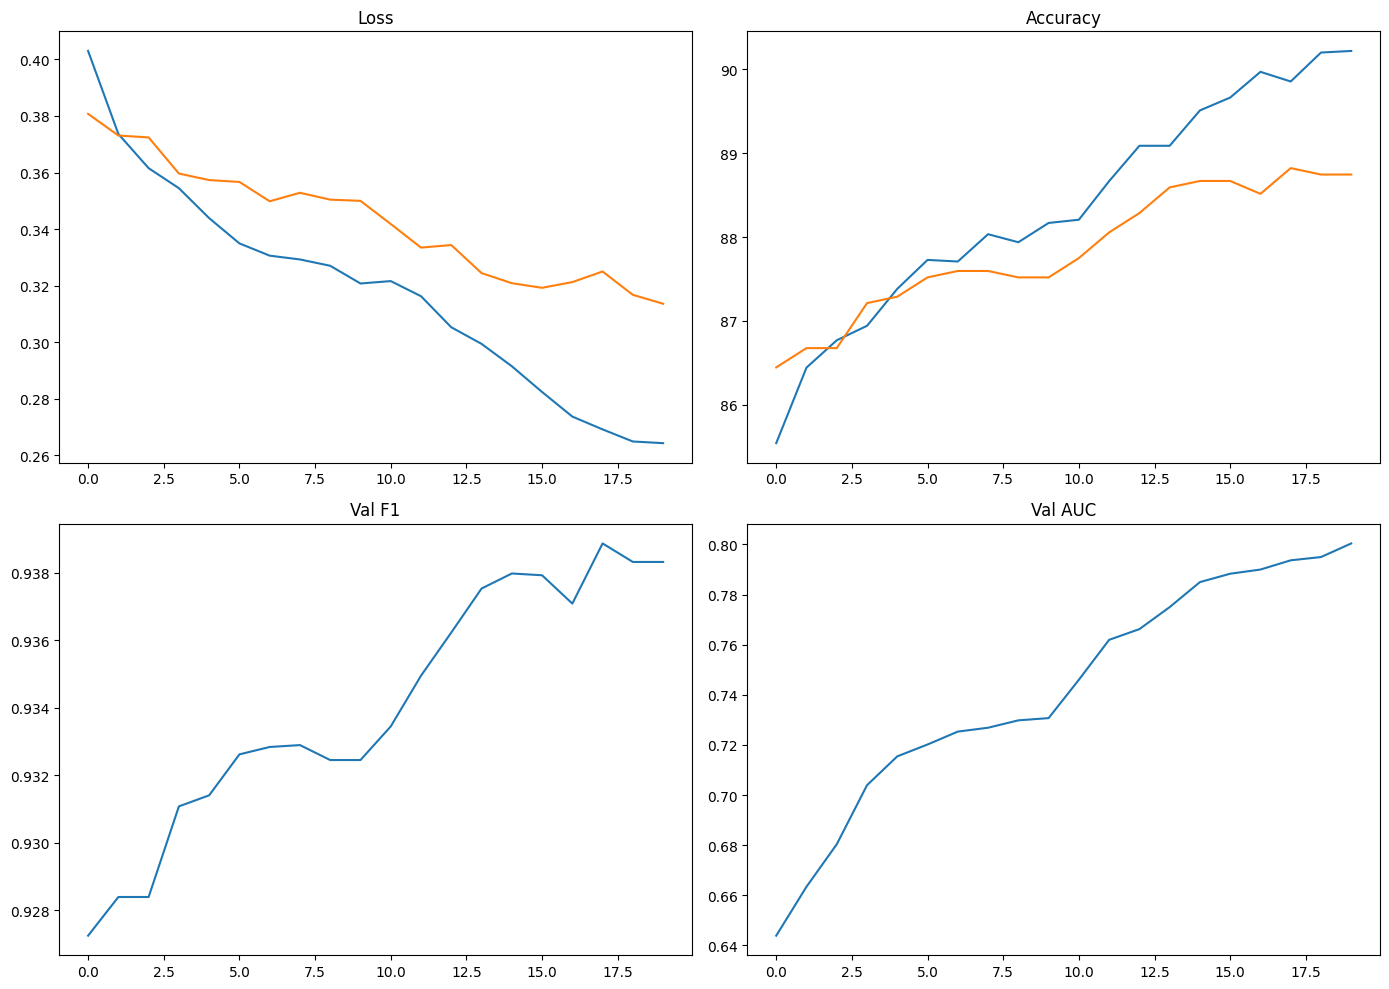


Per-epoch summary:
Epoch 01 | Train loss: 0.4030 | Train acc: 85.54% | Val loss: 0.3807 | Val acc: 86.45% | Val F1: 0.9273 | Val AUC: 0.6439
Epoch 02 | Train loss: 0.3736 | Train acc: 86.44% | Val loss: 0.3731 | Val acc: 86.68% | Val F1: 0.9284 | Val AUC: 0.6634
Epoch 03 | Train loss: 0.3616 | Train acc: 86.77% | Val loss: 0.3724 | Val acc: 86.68% | Val F1: 0.9284 | Val AUC: 0.6803
Epoch 04 | Train loss: 0.3545 | Train acc: 86.94% | Val loss: 0.3597 | Val acc: 87.21% | Val F1: 0.9311 | Val AUC: 0.7039
Epoch 05 | Train loss: 0.3439 | Train acc: 87.38% | Val loss: 0.3573 | Val acc: 87.29% | Val F1: 0.9314 | Val AUC: 0.7154
Epoch 06 | Train loss: 0.3350 | Train acc: 87.73% | Val loss: 0.3567 | Val acc: 87.52% | Val F1: 0.9326 | Val AUC: 0.7202
Epoch 07 | Train loss: 0.3306 | Train acc: 87.71% | Val loss: 0.3499 | Val acc: 87.60% | Val F1: 0.9328 | Val AUC: 0.7253
Epoch 08 | Train loss: 0.3293 | Train acc: 88.03% | Val loss: 0.3529 | Val acc: 87.60% | Val F1: 0.9329 | Val AUC: 0.7269
Epoc

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Scripting failed, falling back to tracing: Compiled functions can't take variable number of arguments or use keyword-only arguments with defaults:
  File "/usr/local/lib/python3.12/dist-packages/transformers/models/vit/configuration_vit.py", line 113
        pooler_output_size=None,
        pooler_act="tanh",
        **kwargs,
         ~~~~~~~ <--- HERE
    ):
        super().__init__(**kwargs)

Saved TorchScript model to: vit_deepfake_scripted.pt
ONNX export failed: No module named 'onnxscript'
TorchScript is available and ONNX may require custom op support.


In [18]:
print("\n=== STEP 13: Run training and visualize results ===")

# ---- Settings ----
NUM_EPOCHS = 20                 # change as you like
CHECKPOINT_DIR = './checkpoints'  # where train_model saves best_model.pth and best_model_state_dict.pth

# Run training (this will print per-epoch train/val loss & acc)
history = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device,
                      num_epochs=NUM_EPOCHS, save_dir=CHECKPOINT_DIR)

# Plot training curves (loss, accuracy, val F1, val AUC)
plot_training_history(history)

# Print numeric summary per epoch
print("\nPer-epoch summary:")
for e in range(len(history['train_loss'])):
    print(f"Epoch {e+1:02d} | Train loss: {history['train_loss'][e]:.4f} | Train acc: {history['train_acc'][e]:.2f}%"
          f" | Val loss: {history['val_loss'][e]:.4f} | Val acc: {history['val_acc'][e]:.2f}%"
          f" | Val F1: {history['val_f1'][e]:.4f} | Val AUC: {history['val_auc'][e]:.4f}")

# ---- Robust load & export helper ----
print("\n=== Robust checkpoint load, re-save clean state_dict, & export (TorchScript + ONNX) ===")
from pathlib import Path
CHECKPOINT_DIR = Path(CHECKPOINT_DIR)
best_state_path = CHECKPOINT_DIR / 'best_model_state_dict.pth'
best_full_path  = CHECKPOINT_DIR / 'best_model.pth'
clean_state_out = CHECKPOINT_DIR / 'best_model_state_dict_clean.pth'
scripted_out = Path('vit_deepfake_scripted.pt')
onnx_out = Path('vit_deepfake.onnx')

def safe_load_state_dict(path, model, device):
    """Try to load a clean state_dict first, else fallbacks to safe full load flows."""
    if path.exists():
        try:
            sd = torch.load(path, map_location=device)
            if isinstance(sd, dict):
                model.load_state_dict(sd)
                print("Loaded clean state_dict from:", path)
                return True
        except Exception as e:
            print("Failed to load state_dict from", path, ":", e)
    # Fallback: try to load the full ckpt safely
    if best_full_path.exists():
        print("Attempting fallback loading of full checkpoint:", best_full_path)
        # 1) Try weights_only=True (safe)
        try:
            tmp = torch.load(best_full_path, map_location=device, weights_only=True)
            print("weights_only=True load succeeded.")
            if isinstance(tmp, dict) and 'model_state_dict' in tmp:
                model.load_state_dict(tmp['model_state_dict'])
                return True
            # if tmp itself is a state-dict:
            if isinstance(tmp, dict) and all(k in model.state_dict() for k in tmp.keys()):
                model.load_state_dict(tmp)
                return True
        except Exception as e:
            print("weights_only=True failed:", e)
        # 2) Try add_safe_globals if available then weights_only=True
        try:
            if hasattr(torch.serialization, 'add_safe_globals'):
                torch.serialization.add_safe_globals([ "numpy._core.multiarray.scalar" ])
                tmp = torch.load(best_full_path, map_location=device, weights_only=True)
                print("Loaded after add_safe_globals + weights_only=True.")
                if isinstance(tmp, dict) and 'model_state_dict' in tmp:
                    model.load_state_dict(tmp['model_state_dict'])
                    return True
        except Exception as e:
            print("add_safe_globals approach failed:", e)
        # 3) Last resort: full legacy load weights_only=False (only trust your own checkpoint)
        try:
            print("Attempting fallback full load with weights_only=False (trusted file)...")
            tmp = torch.load(best_full_path, map_location=device, weights_only=False)
            if isinstance(tmp, dict) and 'model_state_dict' in tmp:
                model.load_state_dict(tmp['model_state_dict'])
                print("Loaded model_state_dict from full checkpoint")
                return True
            # elif it's raw state dict
            if isinstance(tmp, dict) and all(k in model.state_dict() for k in tmp.keys()):
                model.load_state_dict(tmp)
                return True
            print("Full load returned dict keys:", list(tmp.keys())[:20] if isinstance(tmp, dict) else type(tmp))
        except Exception as e:
            print("Full load failed:", e)
    raise RuntimeError("Could not load model weights via safe methods. Check files or recreate training run.")

# Attempt to load weights
try:
    loaded_ok = safe_load_state_dict(best_state_path, model, device)
    if not loaded_ok:
        raise RuntimeError("safe_load_state_dict reported failure")
except Exception as e:
    print("ERROR loading model weights:", e)
    print("Using model as-is (random init).")

# Re-save a clean state_dict to guarantee future safe loads
torch.save(model.state_dict(), clean_state_out)
print("Saved cleaned state_dict to:", clean_state_out)

# Export TorchScript + ONNX
try:
    model_cpu = model.to('cpu').eval()
    dummy = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)
    try:
        scripted = torch.jit.script(model_cpu)
        print("TorchScript scripting succeeded.")
    except Exception as e:
        print("Scripting failed, falling back to tracing:", e)
        scripted = torch.jit.trace(model_cpu, dummy)
    torch.jit.save(scripted, scripted_out)
    print("Saved TorchScript model to:", scripted_out)
except Exception as e:
    print("TorchScript export failed:", e)

try:
    model_cpu.eval()
    input_names = ["pixel_values"]
    output_names = ["logits"]
    dynamic_axes = {"pixel_values": {0: "batch"}, "logits": {0: "batch"}}
    torch.onnx.export(
        model_cpu,
        dummy,
        onnx_out.as_posix(),
        export_params=True,
        opset_version=13,
        do_constant_folding=True,
        input_names=input_names,
        output_names=output_names,
        dynamic_axes=dynamic_axes
    )
    print("ONNX export succeeded:", onnx_out)
except Exception as e:
    print("ONNX export failed:", e)
    print("TorchScript is available and ONNX may require custom op support.")



Final Eval:   0%|          | 0/41 [00:00<?, ?it/s]


=== Final Test Metrics ===
Test Loss: 0.3250
Test Accuracy: 88.82%
Test Precision: 0.8897
Test Recall: 0.9938
Test F1: 0.9389
Test AUC: 0.7937

Confusion matrix (Test set):


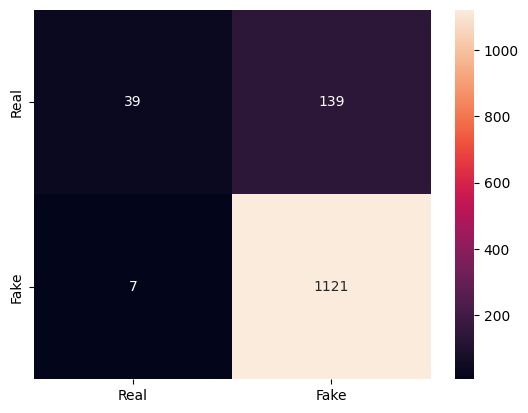


Sample predictions (first 10 test images):
1. id46_id42_0007.jpg | Pred: FAKE (0.824 prob) | True: FAKE
2. id37_id9_0003.jpg | Pred: FAKE (0.977 prob) | True: FAKE
3. id9_0002.jpg | Pred: FAKE (0.904 prob) | True: REAL
4. id45_id48_0005.jpg | Pred: FAKE (0.928 prob) | True: FAKE
5. id21_id16_0005.jpg | Pred: FAKE (0.988 prob) | True: FAKE
6. id45_id46_0003.jpg | Pred: FAKE (0.955 prob) | True: FAKE
7. id20_id19_0008.jpg | Pred: FAKE (0.988 prob) | True: FAKE
8. id28_id3_0009.jpg | Pred: FAKE (0.962 prob) | True: FAKE
9. id38_id33_0005.jpg | Pred: FAKE (0.863 prob) | True: FAKE
10. id53_id58_0005.jpg | Pred: FAKE (0.961 prob) | True: FAKE
Saved: vit_deepfake_final.pth

Done. Clean state saved and exports attempted (TorchScript + ONNX).


In [19]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss=0.0; all_preds=[]; all_labels=[]; all_probs=[]
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Final Eval'):
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(pixel_values)
            loss = criterion(outputs, labels)
            probs = F.softmax(outputs, dim=1)
            _,pred = outputs.max(1)
            running_loss += loss.item()
            all_preds.extend(pred.cpu().numpy()); all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:,1].cpu().numpy())
    n = len(dataloader)
    avg_loss = running_loss / n if n>0 else 0.0
    acc = accuracy_score(all_labels, all_preds) if len(all_labels)>0 else 0.0
    prec, rec, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary') if len(all_labels)>0 else (0,0,0,[0])
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except:
        auc = 0.0
    return {'loss': avg_loss, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'auc': auc, 'preds': all_preds, 'labels': all_labels, 'probs': all_probs}

final_metrics = evaluate_model(model.to(device), test_loader, criterion, device)
print("\n=== Final Test Metrics ===")
print(f"Test Loss: {final_metrics['loss']:.4f}")
print(f"Test Accuracy: {final_metrics['accuracy']*100:.2f}%")
print(f"Test Precision: {final_metrics['precision']:.4f}")
print(f"Test Recall: {final_metrics['recall']:.4f}")
print(f"Test F1: {final_metrics['f1']:.4f}")
print(f"Test AUC: {final_metrics['auc']:.4f}")

print("\nConfusion matrix (Test set):")
plot_confusion_matrix(final_metrics['labels'], final_metrics['preds'])

# Show a few sample predictions (first 10)
print("\nSample predictions (first 10 test images):")
sample_count = min(10, len(final_metrics['labels']))
test_filenames = [str(Path(DATA_DIR) / row['image_path']) for _, row in test_df.reset_index(drop=True).iterrows()]
for i in range(sample_count):
    try:
        img_path = test_filenames[i]
        pred_label = final_metrics['preds'][i]
        true_label = final_metrics['labels'][i]
        pred_text = 'FAKE' if pred_label==1 else 'REAL'
        true_text = 'FAKE' if true_label==1 else 'REAL'
        conf = final_metrics['probs'][i] if i < len(final_metrics['probs']) else None
        print(f"{i+1}. {Path(img_path).name} | Pred: {pred_text} ({conf:.3f} prob) | True: {true_text}")
    except Exception as e:
        print(f"{i+1}. (could not display filename) Pred: {final_metrics['preds'][i]} True: {final_metrics['labels'][i]}")

# Save final model for inference (optional)
save_model_for_inference(model, save_path='vit_deepfake_final.pth')
print("\nDone. Clean state saved and exports attempted (TorchScript + ONNX).")


In [20]:
def quick_boot_after_reconnect(checkpoint_dir='./checkpoints', data_dir=None):
    """
    Minimal steps to run after a Colab reconnect:
      - re-define DATA_DIR (if needed)
      - reload labels CSV (if present)
      - recreate datasets, dataloaders, model, transforms
      - load clean state_dict if present
      - run evaluation
    Usage: re-run the cell that defines functions/classes above and then call:
       quick_boot_after_reconnect(checkpoint_dir='./checkpoints', data_dir='/content/your_dataset')
    """
    print("Quick-boot starting...")
    # Set data dir if provided
    if data_dir is not None:
        global DATA_DIR, p, train_df, test_df, train_dataset, test_dataset, train_loader, test_loader
        DATA_DIR = data_dir
        p = Path(DATA_DIR)
        # reload CSV if exists
        csvp = p / 'labels_by_heuristic.csv'
        if csvp.exists():
            df = pd.read_csv(csvp)
        else:
            raise RuntimeError("labels_by_heuristic.csv not found in provided data_dir.")
        train_df_local, test_df_local = train_test_split(df, test_size=0.20, stratify=df['label'], random_state=42)
        train_df = train_df_local; test_df = test_df_local
        train_dataset = DeepfakeCsvDataset(train_df, DATA_DIR, transform=train_transforms)
        test_dataset  = DeepfakeCsvDataset(test_df,  DATA_DIR, transform=val_transforms)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
        test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
        print("Datasets and loaders recreated.")
    # Recreate model and load clean state_dict if available
    global model, optimizer, scheduler
    model = ViTDeepfakeDetector(pretrained=True).to(device)
    # try to load clean state_dict
    sd_path = Path(checkpoint_dir) / 'best_model_state_dict.pth'
    if sd_path.exists():
        sd = torch.load(sd_path, map_location=device)
        model.load_state_dict(sd)
        print("Loaded clean state_dict from", sd_path)
    else:
        print("Clean state_dict not found at", sd_path, "- you can run safe loader later.")
    return model, train_loader, test_loader

In [21]:
print("\n" + "="*70)
print("Updated pipeline ready. Important files saved under ./checkpoints:")
print(" - best_model.pth (full checkpoint)")
print(" - best_model_state_dict.pth (clean state_dict)")
print(" - best_model_state_dict_clean.pth (re-saved clean state_dict after load)")
print("Exports (if succeeded): vit_deepfake_scripted.pt, vit_deepfake.onnx, vit_deepfake_final.pth")
print("="*70)


Updated pipeline ready. Important files saved under ./checkpoints:
 - best_model.pth (full checkpoint)
 - best_model_state_dict.pth (clean state_dict)
 - best_model_state_dict_clean.pth (re-saved clean state_dict after load)
Exports (if succeeded): vit_deepfake_scripted.pt, vit_deepfake.onnx, vit_deepfake_final.pth


In [22]:
from google.colab import files
files.download('vit_deepfake_scripted.pt')  # change to desired filename

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>